In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
df.rename(columns={'Passengers': 'Umsatz'}, inplace=True) # Umbenennung für Konsistenz mit Vorlesungsbeispiel

df['Monat'] = df.index.month
df['t'] = df.index.year + (df.index.month - 1) / 12

print("Daten und Bibliotheken sind bereit.")
df.head()

Daten und Bibliotheken sind bereit.


,Umsatz,Monat,t
Month,,,
1949-01-01,112,1,1949.000000
1949-02-01,118,2,1949.083333
1949-03-01,132,3,1949.166667
1949-04-01,129,4,1949.250000
1949-05-01,121,5,1949.333333


**1. Statistischer Test auf Stationarität (ADF-Test)**

In Notebook 1 haben wir visuell festgestellt, dass unsere Zeitreihe nicht stationär ist. Ein statistischer Test kann diese Vermutung formal bestätigen. Der am häufigsten verwendete Test ist der Augmented Dickey-Fuller (ADF) Test.

Bezug zur Vorlesung: Der Test prüft eine spezifische Form der Nicht-Stationarität (eine sog. "unit root").

Nullhypothese (H0): Die Zeitreihe ist nicht stationär.
Alternative Hypothese (H1): Die Zeitreihe ist stationär.
Wir interpretieren das Ergebnis anhand des p-Wertes:

- Wenn p-Wert <= 0.05: Wir verwerfen die Nullhypothese. Die Daten sind wahrscheinlich stationär.
- Wenn p-Wert > 0.05: Wir können die Nullhypothese nicht verwerfen. Die Daten sind wahrscheinlich nicht stationär.

In [2]:
# --- Schritt 2: ADF-Test auf die Originaldaten anwenden ---
adf_result = adfuller(df['Umsatz'])
print('ADF Statistik: %f' % adf_result[0])
print('p-Wert: %f' % adf_result[1])
print('Kritische Werte:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

if adf_result[1] > 0.05:
    print("\nErgebnis: Der p-Wert ist größer als 0.05. Wir können die Nullhypothese nicht verwerfen. Die Zeitreihe ist NICHT stationär.")
else:
    print("\nErgebnis: Der p-Wert ist kleiner oder gleich 0.05. Wir verwerfen die Nullhypothese. Die Zeitreihe IST stationär.")

ADF Statistik: 0.815369
p-Wert: 0.991880
Kritische Werte:
	1%: -3.482
	5%: -2.884
	10%: -2.579

Ergebnis: Der p-Wert ist größer als 0.05. Wir können die Nullhypothese nicht verwerfen. Die Zeitreihe ist NICHT stationär.


___
**2. Trendbereinigung durch Differenzbildung**

Der ADF-Test hat bestätigt, was wir gesehen haben. Unser erster Schritt zur Stationarisierung ist die Entfernung des Trends.

Bezug zur Vorlesung: Wie auf Folie "Zeitreihen stationär machen (1)" beschrieben, ist die Differenzbildung die gängigste Methode, um einen linearen Trend zu entfernen. Wir berechnen die Differenz zwischen einem Wert und seinem direkten Vorgänger: Y 

∗t=Y_t−Y∗t−1. In pandas geht das sehr einfach mit der .diff()-Methode. Dies entspricht der Komponente "I" (Integrated) mit dem Parameter d=1 in einem ARIMA-Modell.

In [16]:
df['Trend_bereinigt'] = df['Umsatz'].diff(1)

fig = px.line(
    df.dropna(), 
    y='Trend_bereinigt', 
    title='Zeitreihe nach erster Differenzbildung (Trend entfernt)',
    labels={'Month': 'Datum', 'Trend_bereinigt': 'Differenz der Passagiere'}
)
fig.update_layout(title_x=0.5)
fig.show()

**Interpretation**

Der Aufwärtstrend ist verschwunden! Die Zeitreihe schwankt nun um einen Mittelwert nahe null. Allerdings ist das starke saisonale Muster immer noch deutlich zu erkennen. Wir testen erneut mit dem ADF-Test.

In [17]:
adf_result_diff1 = adfuller(df['Trend_bereinigt'].dropna())
print(f"ADF-Test nach Trendbereinigung:")
print('p-Wert: %f' % adf_result_diff1[1])

ADF-Test nach Trendbereinigung:
p-Wert: 0.054213


Der p-Wert ist zwar gesunken, aber immer noch zu hoch. Die verbleibende Saisonalität verhindert, dass die Reihe stationär ist.

___

**Saisonbereinigung durch saisonale Differenzbildung**

Nun entfernen wir die saisonale Komponente.

Bezug zur Vorlesung: Hierzu verwenden wir die "Differenzbildung mit größerer Verzögerung". Da wir eine jährliche Saisonalität mit einer Periodenlänge s=12 haben, bilden wir die Differenz zum Wert des Vorjahres: Y 
′′
 _t=Y 
′
 ∗t−Y 
′
 ∗t−12. Dies entspricht dem saisonalen "I" mit dem Parameter D=1 in einem SARIMA-Modell.



In [18]:
df['Saison_bereinigt'] = df['Trend_bereinigt'].diff(12)

fig = px.line(
    df.dropna(), 
    y='Saison_bereinigt', 
    title='Zeitreihe nach Trend- und Saisonbereinigung',
    labels={'Month': 'Datum', 'Saison_bereinigt': 'Saisonale Differenz'}
)
fig.update_layout(title_x=0.5)
fig.show()

# --- Finaler ADF-Test ---
adf_result_final = adfuller(df['Saison_bereinigt'].dropna())
print(f"Finaler ADF-Test nach Saisonbereinigung:")
print('p-Wert: %f' % adf_result_final[1])

Finaler ADF-Test nach Saisonbereinigung:
p-Wert: 0.000000


 Der Plot sieht nun aus wie zufälliges Rauschen ohne erkennbare Muster. Der p-Wert des ADF-Tests ist jetzt extrem klein (deutlich unter 0.05). Wir können die Nullhypothese mit großer Sicherheit verwerfen und annehmen, dass unsere transformierte Zeitreihe **stationär** ist.
 ___

**Dekomposition durch Modellierung (wie in der Vorlesung)**

Schritt A: Trendbereinigung durch lineare Regression
Wir fitten eine Gerade durch die Datenpunkte und ziehen diese Trendlinie von den Originaldaten ab.

Text(0, 0.5, 'x_t')

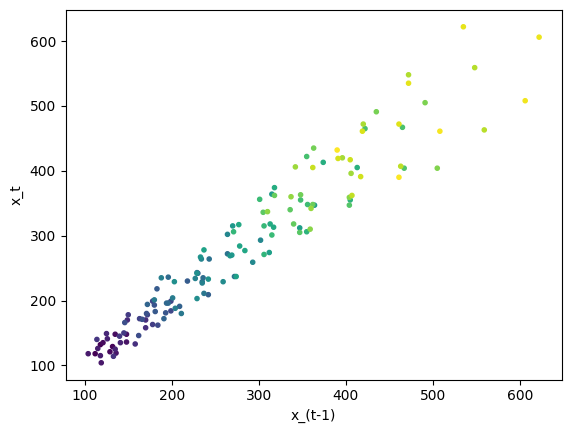

In [20]:
df['Umsatz_t-1'] = df['Umsatz'].shift(1)
df['Umsatz_t-2'] = df['Umsatz'].shift(2)

plt.scatter(df['Umsatz_t-1'],df.Umsatz,marker='.',c=df.index)
plt.xlabel('x_(t-1)')
plt.ylabel('x_t')

In [21]:
df[['Umsatz','Umsatz_t-1']].corr()

,Umsatz,Umsatz_t-1
Umsatz,1.000000,0.960195
Umsatz_t-1,0.960195,1.000000


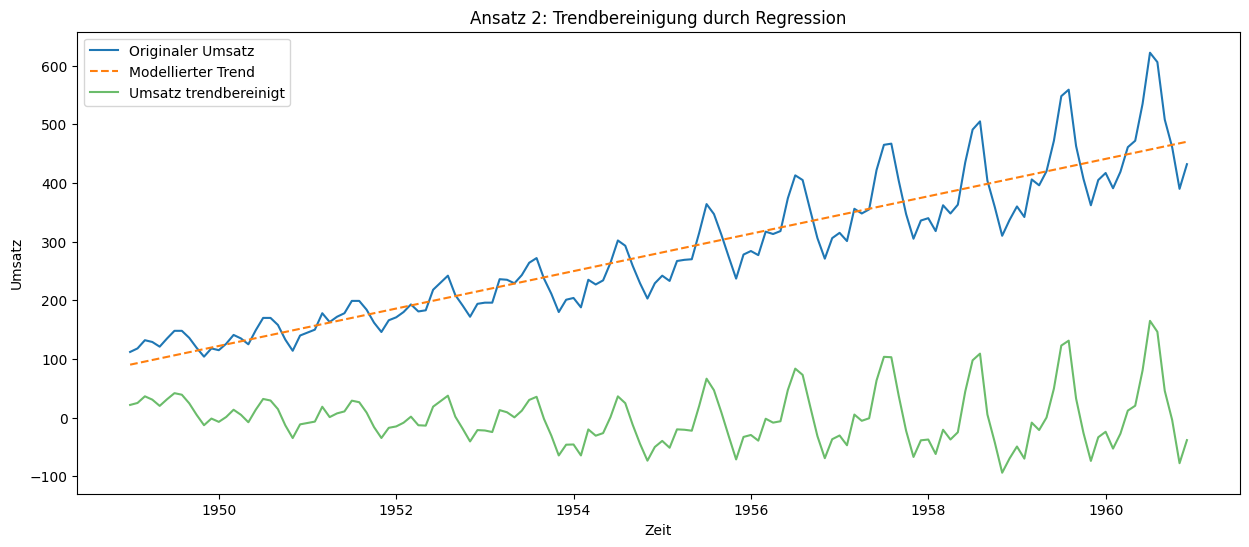

,U_trendbereinigt,Umsatz_bereinigt_t-1
U_trendbereinigt,1.000000,0.730574
Umsatz_bereinigt_t-1,0.730574,1.000000


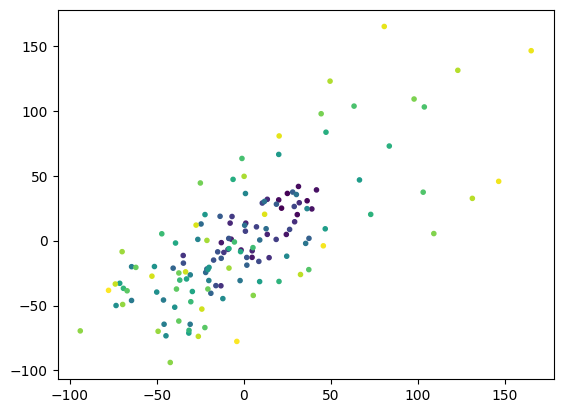

In [23]:
X = sm.add_constant(df['t'])
y = df['Umsatz']

model = sm.OLS(y, X).fit()

df['trend_modelliert'] = model.predict(X)

df['U_trendbereinigt'] = df['Umsatz'] - df['trend_modelliert']

plt.figure(figsize=(15,6))
plt.plot(df['t'], df['Umsatz'], label='Originaler Umsatz')
plt.plot(df['t'], df['trend_modelliert'], label='Modellierter Trend', linestyle='--')
plt.plot(df['t'], df['U_trendbereinigt'], label='Umsatz trendbereinigt', alpha=0.7)
plt.title('Ansatz 2: Trendbereinigung durch Regression')
plt.xlabel('Zeit')
plt.ylabel('Umsatz')
plt.legend()
plt.show()

df['Umsatz_bereinigt_t-1'] = df['U_trendbereinigt'].shift(1)
plt.scatter(df['Umsatz_bereinigt_t-1'], df['U_trendbereinigt'], marker='.', c=df.index)

df[['U_trendbereinigt','Umsatz_bereinigt_t-1']].corr()

Schritt B: Saisonbereinigung durch Abzug des Monatsmittels

Nun nehmen wir die trendbereinigte Zeitreihe und entfernen die verbleibende Periodizität, indem wir für jeden Monat seinen durchschnittlichen Effekt berechnen und abziehen.

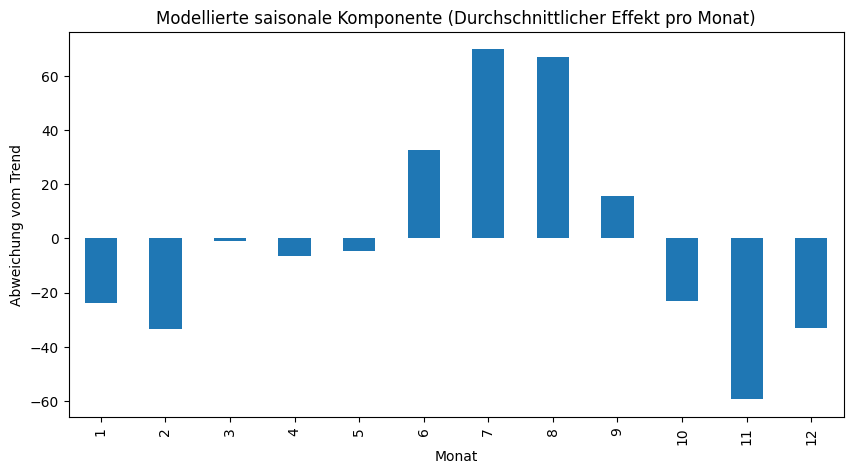

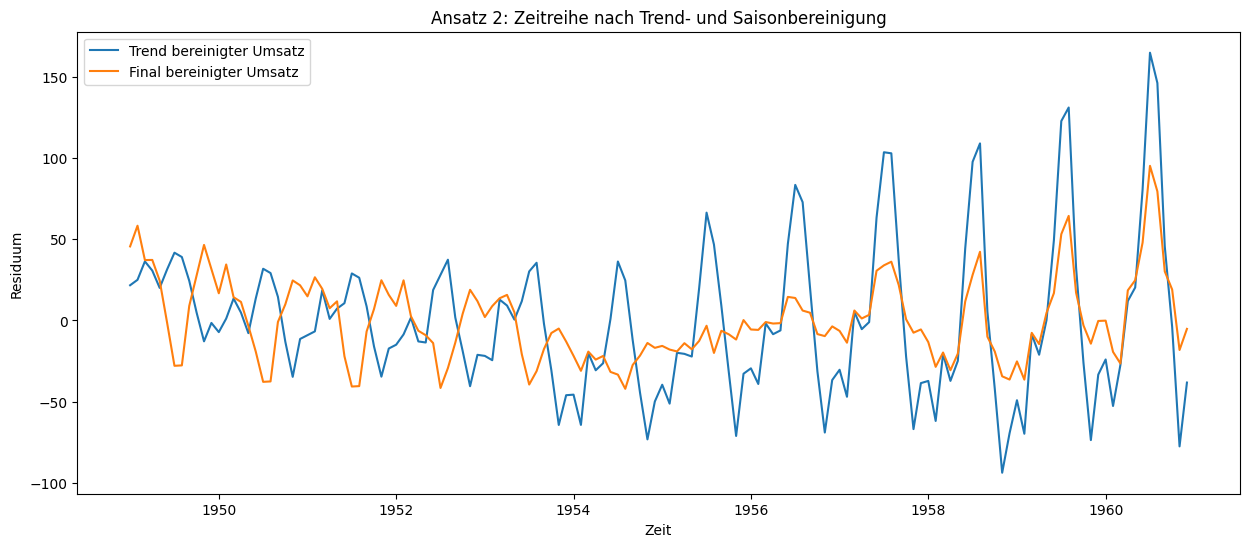

                       U_final_bereinigt  U_final_bereinigt_t-1
U_final_bereinigt               1.000000               0.772398
U_final_bereinigt_t-1           0.772398               1.000000

ADF-Test nach Dekomposition:
p-Wert: 0.271611


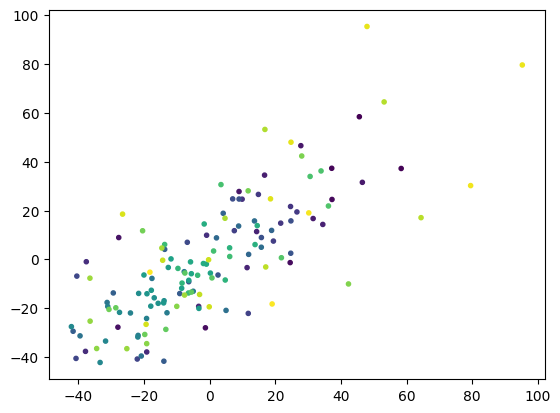

In [25]:
# --- Schritt 5: Saisonale Komponente schätzen und entfernen ---

month_averages = df.groupby('Monat')['U_trendbereinigt'].mean()
month_averages.rename("saison_modelliert", inplace=True)

# Visualisierung der saisonalen Komponente
month_averages.plot(kind='bar', figsize=(10,5))
plt.title('Modellierte saisonale Komponente (Durchschnittlicher Effekt pro Monat)')
plt.ylabel('Abweichung vom Trend')
plt.show()

# Die Monatsdurchschnitte wieder mit dem Haupt-DataFrame verbinden
#df = df.join(month_averages, on='Monat')

# Saisonale Komponente von der trendbereinigten Reihe abziehen
df['U_final_bereinigt'] = df['U_trendbereinigt'] - df['saison_modelliert']

# Visualisierung der finalen Zeitreihe
plt.figure(figsize=(15,6))
plt.plot(df['t'], df['U_trendbereinigt'], label='Trend bereinigter Umsatz')
plt.plot(df['t'], df['U_final_bereinigt'], label='Final bereinigter Umsatz')
plt.title('Ansatz 2: Zeitreihe nach Trend- und Saisonbereinigung')
plt.xlabel('Zeit')
plt.ylabel('Residuum')
plt.legend()
plt.show()

df['U_final_bereinigt_t-1'] = df['U_final_bereinigt'].shift(1)
plt.scatter(df['U_final_bereinigt_t-1'], df['U_final_bereinigt'], marker='.', c=df.index)
print(df[['U_final_bereinigt', 'U_final_bereinigt_t-1']].corr())

# --- Schritt 6: Finaler ADF-Test für Ansatz 2 ---
adf_result_dekomp = adfuller(df['U_final_bereinigt'].dropna())
print(f"\nADF-Test nach Dekomposition:")
print('p-Wert: %f' % adf_result_dekomp[1])

___
**3. Varianz-Dekomposition (Analyse aus der Vorlesung)**

Ein großer Vorteil von Ansatz 2 ist, dass wir die expliziten Komponenten (Trend, Saison) haben. Wir können nun analysieren, wie viel der Gesamt-Schwankung (Varianz) auf die einzelnen Komponenten zurückzuführen ist.

In [26]:
# --- Schritt 7: Varianz der Komponenten berechnen ---

# Varianzen der einzelnen Zeitreihen berechnen
varianzen = df[['Umsatz','trend_modelliert','U_final_bereinigt']].var()
# Varianz der saisonalen Komponente hinzufügen
varianzen['saison_modelliert'] = df['saison_modelliert'].var()

# Anteile an der Gesamtvarianz berechnen
varianz_anteile = varianzen / varianzen['Umsatz']

# Ergebnisse ausgeben
print("Analyse der Varianzanteile:")
print(varianz_anteile)

print("\nVon der Gesamtvarianz der Zeitreihe werden %2.1f%% durch den Trend erklärt, %2.1f%% durch die Saisonalität und %2.1f%% sind andere, unregelmäßige Schwankungen." %
    (100.0 * varianz_anteile.trend_modelliert,
     100.0 * varianz_anteile.saison_modelliert,
     100.0 * varianz_anteile.U_final_bereinigt))

Analyse der Varianzanteile:
Umsatz               1.000000
trend_modelliert     0.853638
U_final_bereinigt    0.044130
saison_modelliert    0.102231
dtype: float64

Von der Gesamtvarianz der Zeitreihe werden 85.4% durch den Trend erklärt, 10.2% durch die Saisonalität und 4.4% sind andere, unregelmäßige Schwankungen.
